# Lectura y Análisis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [3]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [4]:
# Read the CSV files
directory = "data/"
orotava_openmetoe_arpege = "openmeteo_orotava_arpege.csv"
orotava_openmetoe_icon = "openmeteo_orotava_icon.csv"

orotava_grafcan = "grafcan_orotava.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [orotava_openmetoe_arpege,
              orotava_openmetoe_icon,
              orotava_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_orotava_arpege.csv...
Processing openmeteo_orotava_icon.csv...
Processing grafcan_orotava.csv...


## Visualización

In [5]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

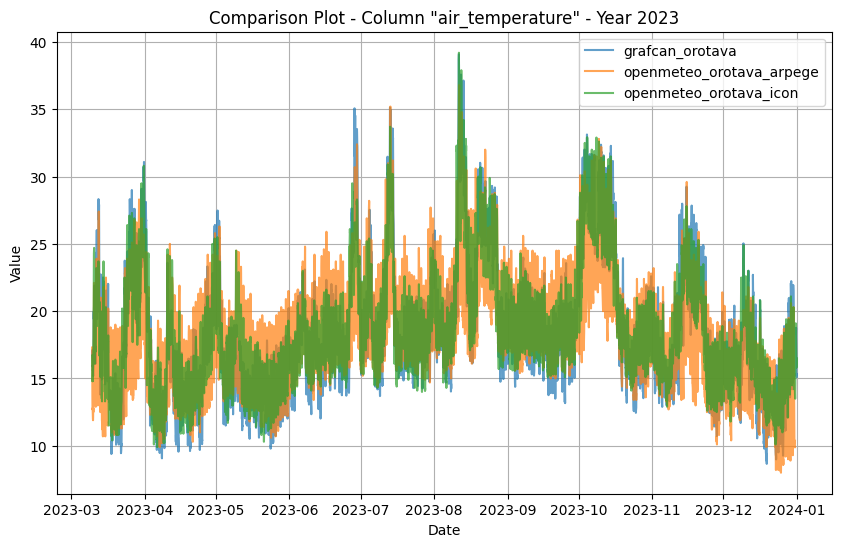

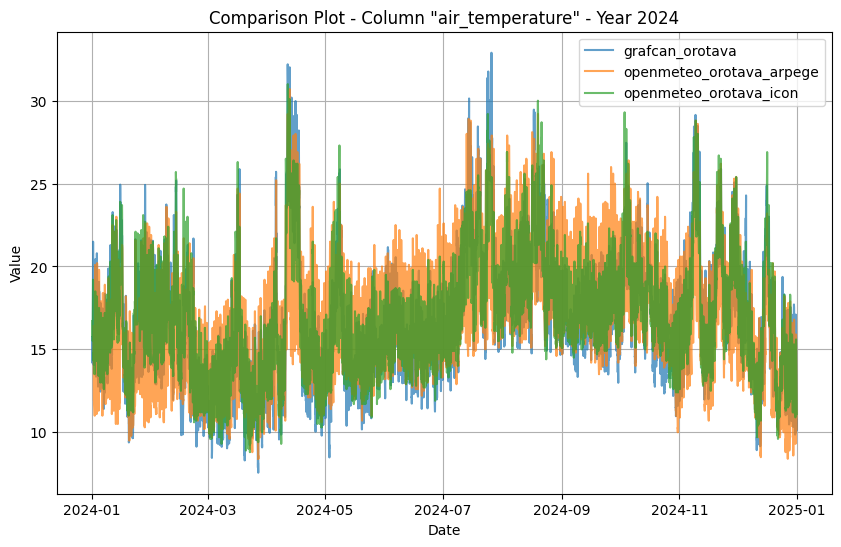

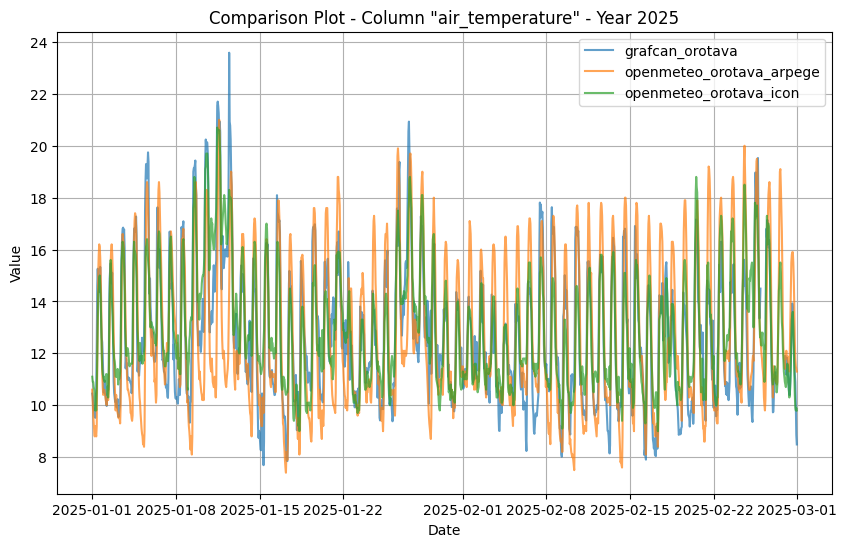

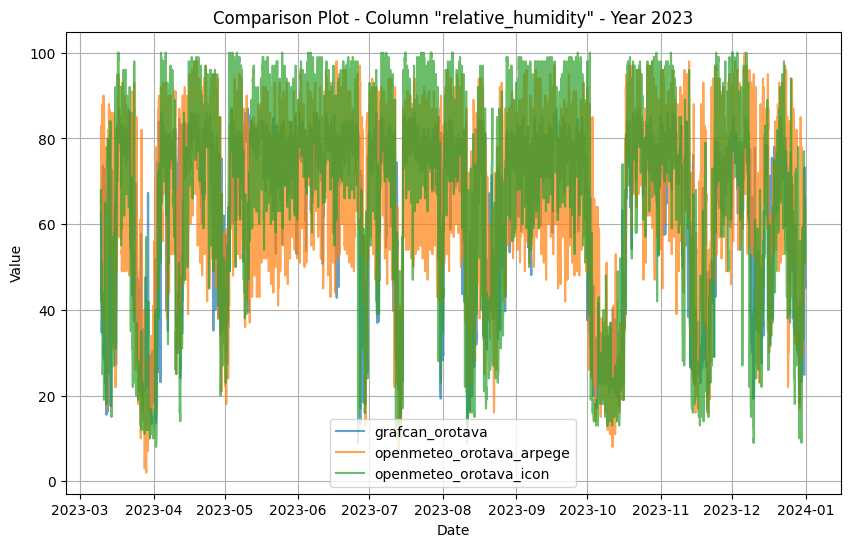

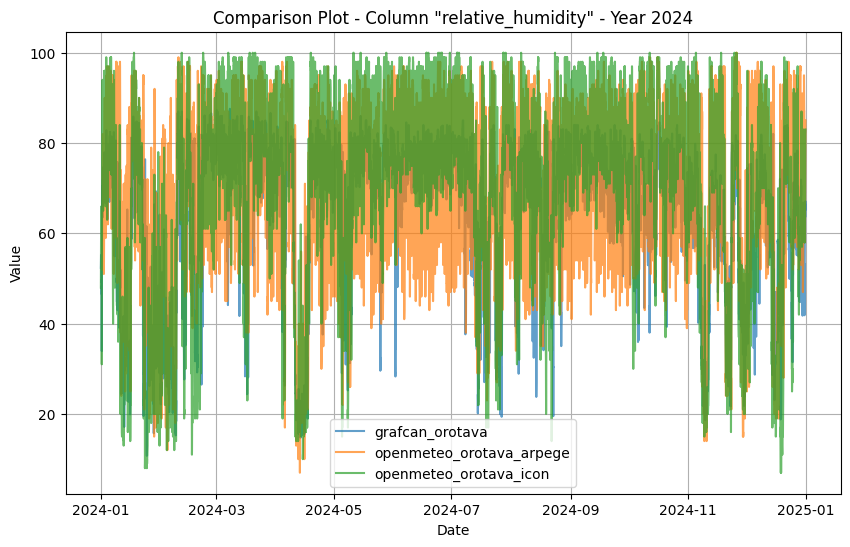

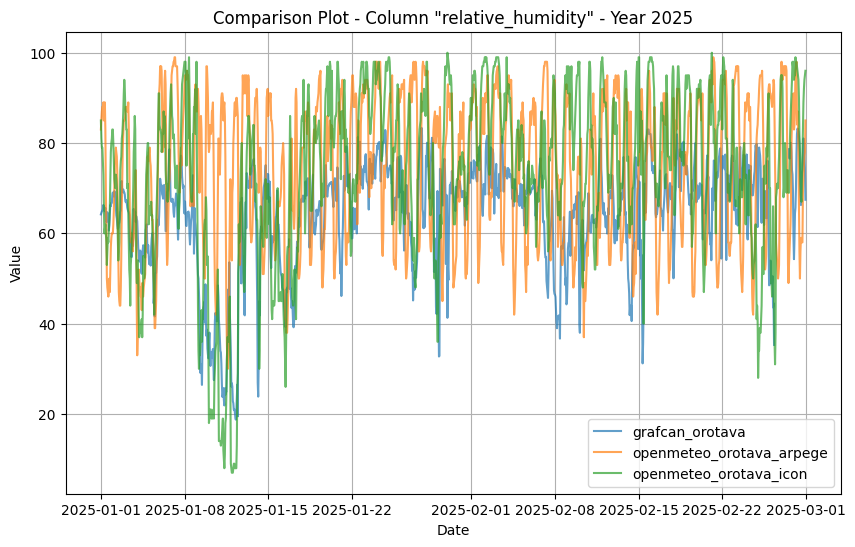

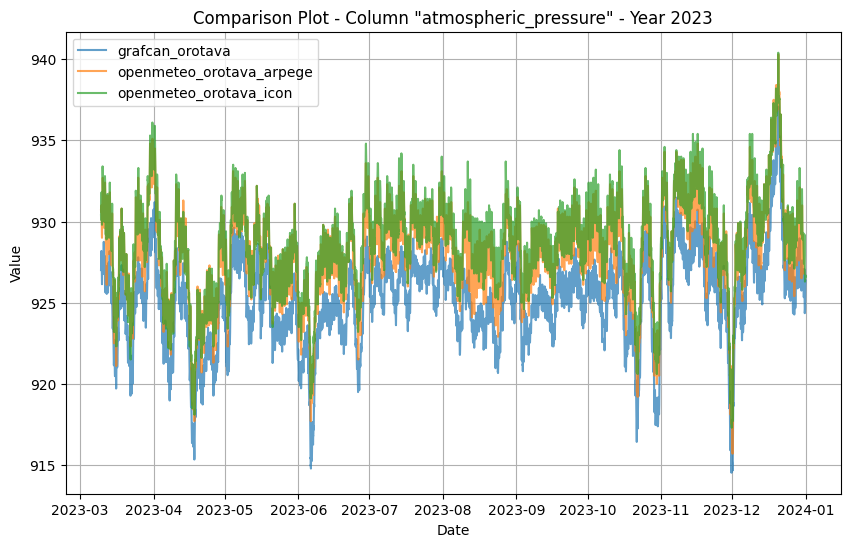

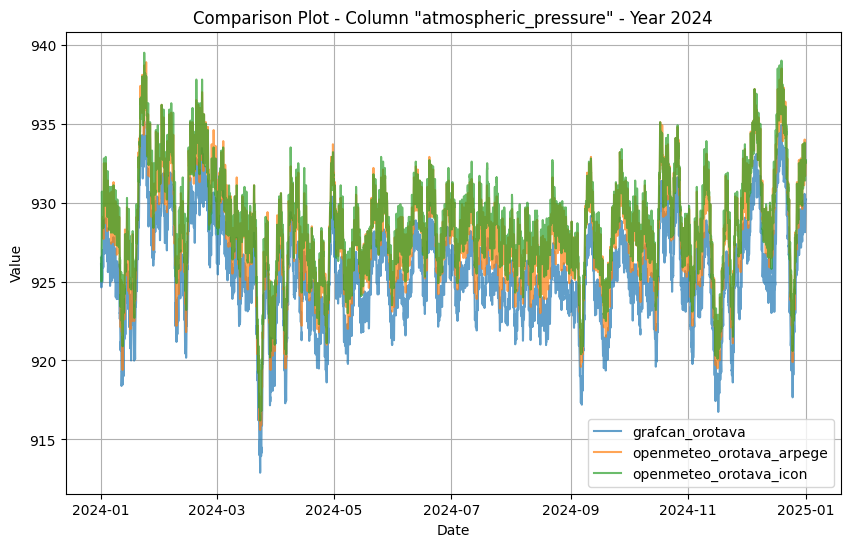

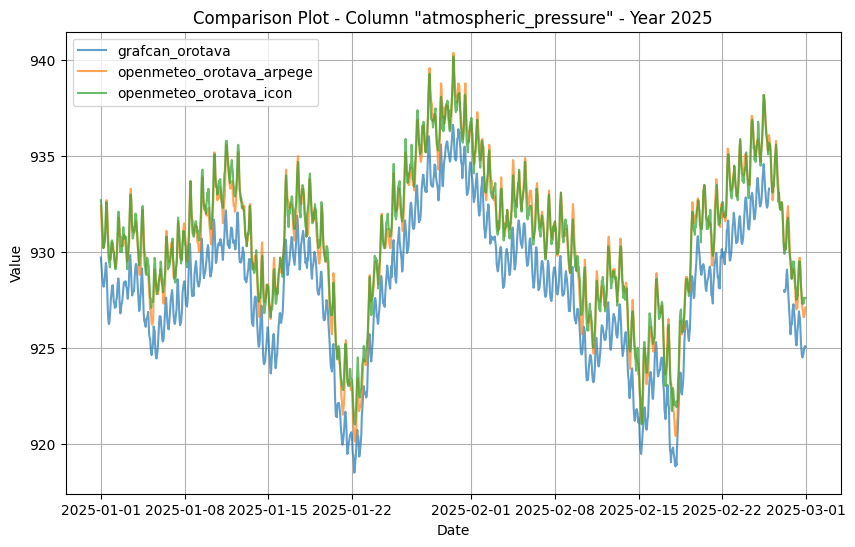

In [6]:
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "air_temperature")
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "relative_humidity")
plot_datasets([orotava_grafcan, orotava_openmetoe_arpege, orotava_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [7]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours)
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_orotava_arpege after resampling:
DatetimeIndex(['2023-12-31 07:00:00+00:00', '2023-12-31 08:00:00+00:00',
               '2023-12-31 09:00:00+00:00', '2023-12-31 10:00:00+00:00',
               '2023-12-31 11:00:00+00:00', '2023-12-31 12:00:00+00:00',
               '2023-12-31 13:00:00+00:00', '2023-12-31 14:00:00+00:00',
               '2023-12-31 15:00:00+00:00', '2023-12-31 16:00:00+00:00',
               '2023-12-31 17:00:00+00:00', '2023-12-31 18:00:00+00:00',
               '2023-12-31 19:00:00+00:00', '2023-12-31 20:00:00+00:00',
               '2023-12-31 21:00:00+00:00', '2023-12-31 22:00:00+00:00',
               '2023-12-31 23:00:00+00:00', '2024-01-01 00:00:00+00:00',
               '2024-01-01 01:00:00+00:00', '2024-01-01 02:00:00+00:00',
               '2024-01-01 03:00:00+00:00', '2024-01-01 04:00:00+00:00',
               '2024-01-01 05:00:00+00:00', '2024-01-01 06:00:00+00:00',
               '2024-01-01 07:00:00+00:00', '2024-01-01 08:00:00

### Manejo Horas faltantes

In [8]:
# Cubic Spline Interpolation Algorithm

def cubic_spline_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [9]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    cubic_spline_interpolation(df_hourly)

## Comparativa datasets predicciones

In [10]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [11]:
datasets_similarity(orotava_openmetoe_icon, orotava_grafcan)

Similarity Metrics for openmeteo_orotava_icon vs grafcan_orotava
  air_temperature:
    Pearson: 0.9238
    Spearman: 0.9213
    Kendall: 0.7610
    MSE: 3.0458
    Euclidean Distance: 229.7664
  atmospheric_pressure:
    Pearson: 0.9633
    Spearman: 0.9509
    Kendall: 0.8203
    MSE: 12.5405
    Euclidean Distance: 466.2231
  relative_humidity:
    Pearson: 0.7630
    Spearman: 0.6291
    Kendall: 0.4566
    MSE: 254.7724
    Euclidean Distance: 2101.4211


In [12]:
datasets_similarity(orotava_openmetoe_arpege, orotava_grafcan)

Similarity Metrics for openmeteo_orotava_arpege vs grafcan_orotava
  air_temperature:
    Pearson: 0.8089
    Spearman: 0.8187
    Kendall: 0.6331
    MSE: 7.5858
    Euclidean Distance: 362.6089
  atmospheric_pressure:
    Pearson: 0.9653
    Spearman: 0.9530
    Kendall: 0.8225
    MSE: 9.1352
    Euclidean Distance: 397.9196
  relative_humidity:
    Pearson: 0.4113
    Spearman: 0.2946
    Kendall: 0.2016
    MSE: 441.3494
    Euclidean Distance: 2765.8470


In [13]:
# Media de datasets openmeteo
dataframes["openmeteo_avg"] = (dataframes["openmeteo_orotava_arpege"] + dataframes["openmeteo_orotava_icon"]) / 2
datasets_similarity("openmeteo_avg", orotava_grafcan)

Similarity Metrics for openmeteo_avg vs grafcan_orotava
  air_temperature:
    Pearson: 0.8985
    Spearman: 0.9035
    Kendall: 0.7318
    MSE: 4.0214
    Euclidean Distance: 264.0126
  atmospheric_pressure:
    Pearson: 0.9689
    Spearman: 0.9578
    Kendall: 0.8318
    MSE: 10.6638
    Euclidean Distance: 429.9257
  relative_humidity:
    Pearson: 0.6771
    Spearman: 0.5503
    Kendall: 0.3869
    MSE: 245.9642
    Euclidean Distance: 2064.7756


## Detección de outliers



In [14]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_orotava_arpege:


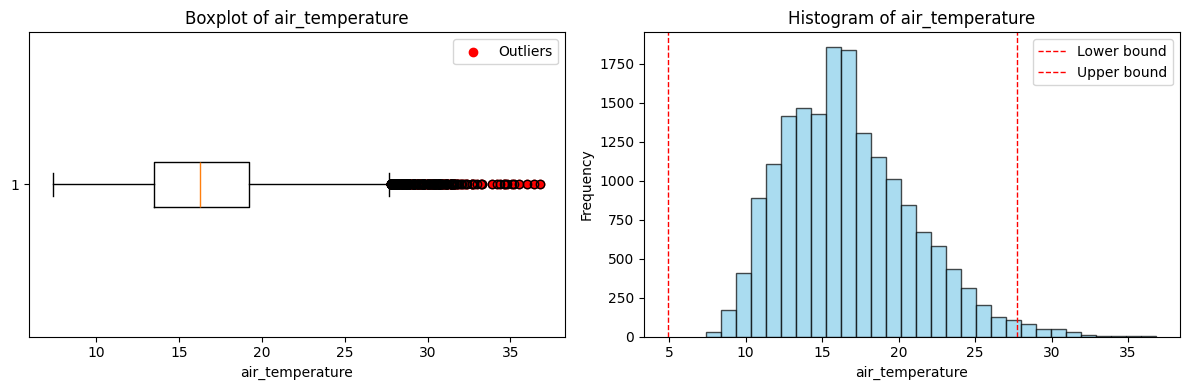

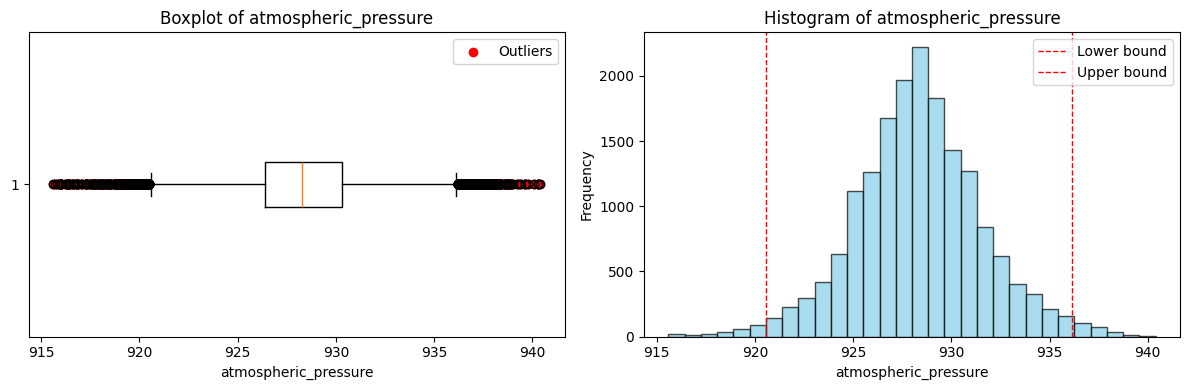

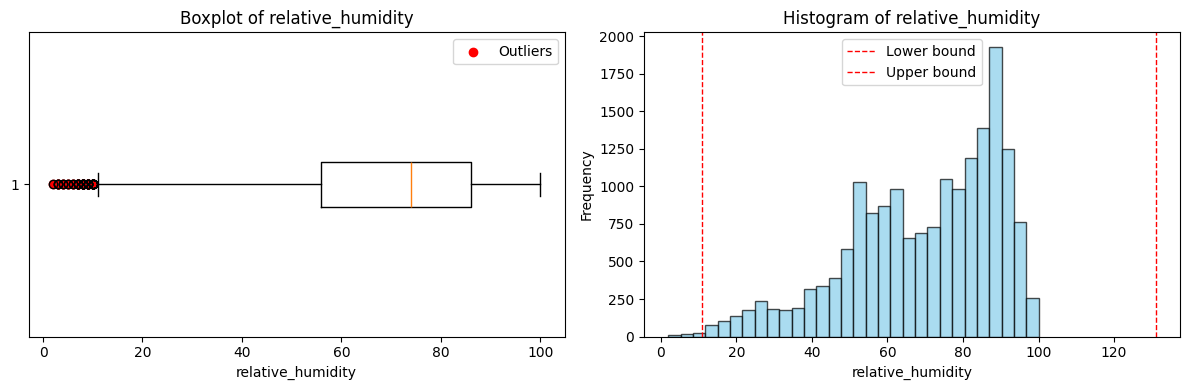

  air_temperature outlier row indices: [Timestamp('2023-03-29 13:00:00+0000', tz='UTC'), Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 17:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-07-04 14:00:00+0000', tz='UTC'), Timestamp('2023-07-04 15:00:00+0000', tz='UTC'), Timestamp('2023-07-04 16:00:00+0000', tz='UTC'), Timestamp('2023-07-11 12:00:0

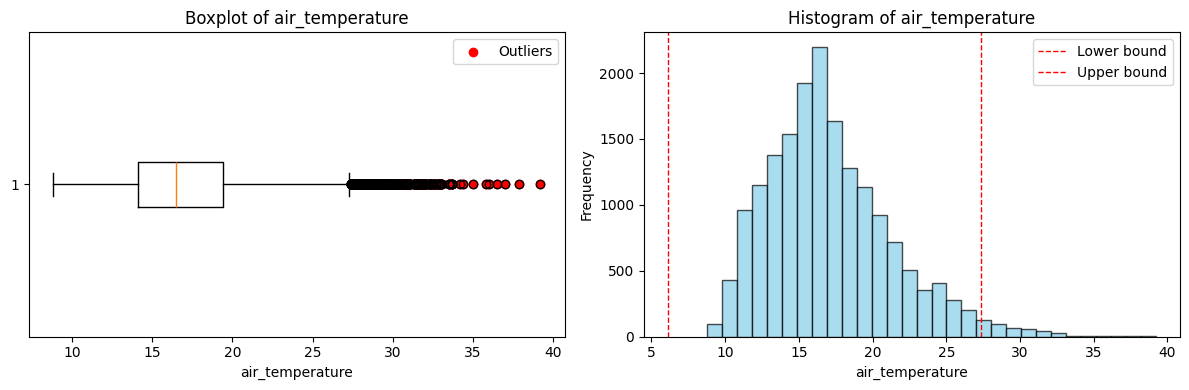

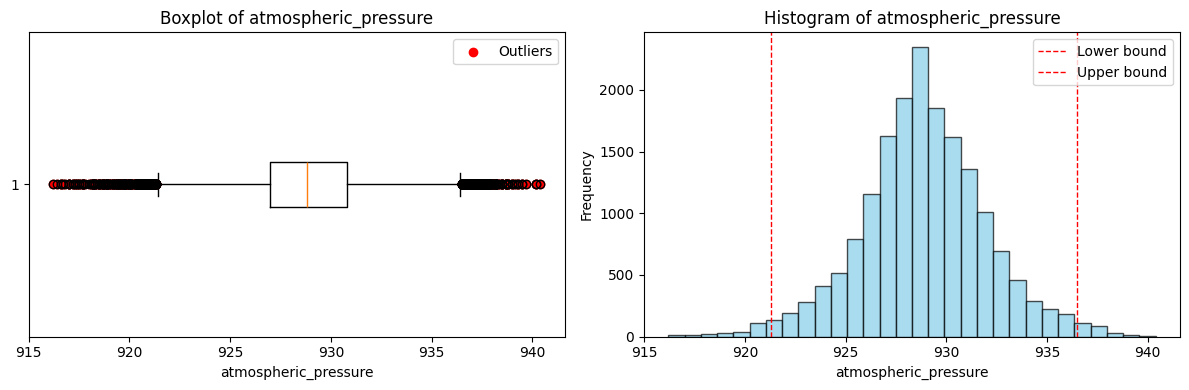

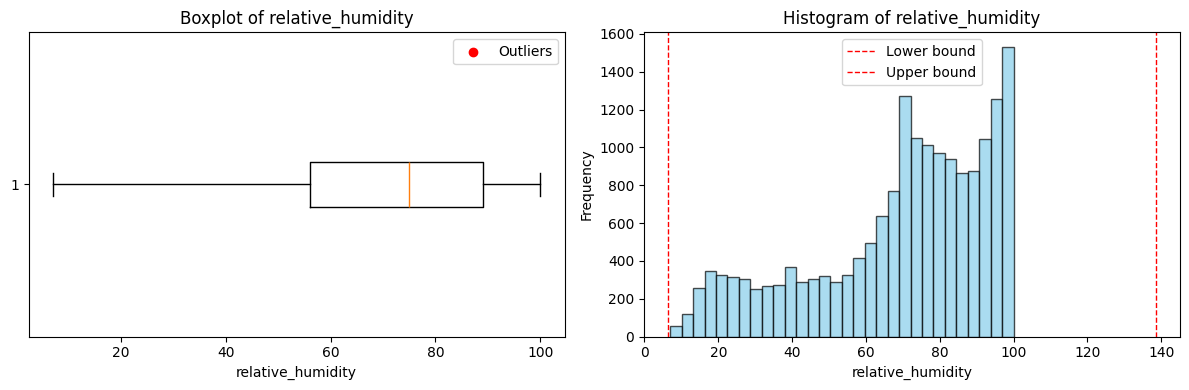

  air_temperature outlier row indices: [Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:00+0000', tz='UTC'), Timestamp('2023-03-31 10:00:00+0000', tz='UTC'), Timestamp('2023-03-31 11:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 17:00:00+0000', tz='UTC'), Timestamp('2023-03-31 18:00:00+0000', tz='UTC'), Timestamp('2023-06-27 12:00:00+0000', tz='UTC'), Timestamp('2023-06-27 13:00:00+0000', tz='UTC'), Timestamp('2023-06-27 14:00:00+0000', tz='UTC'), Timestamp('2023-06-27 15:00:0

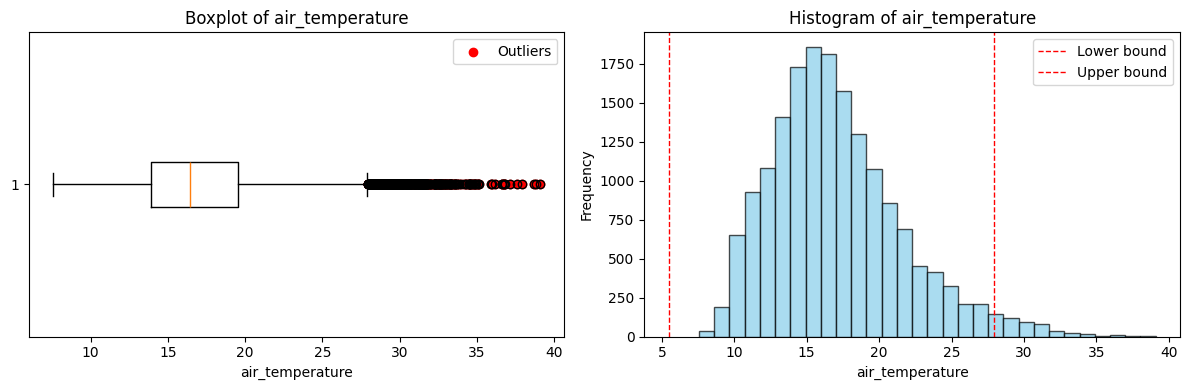

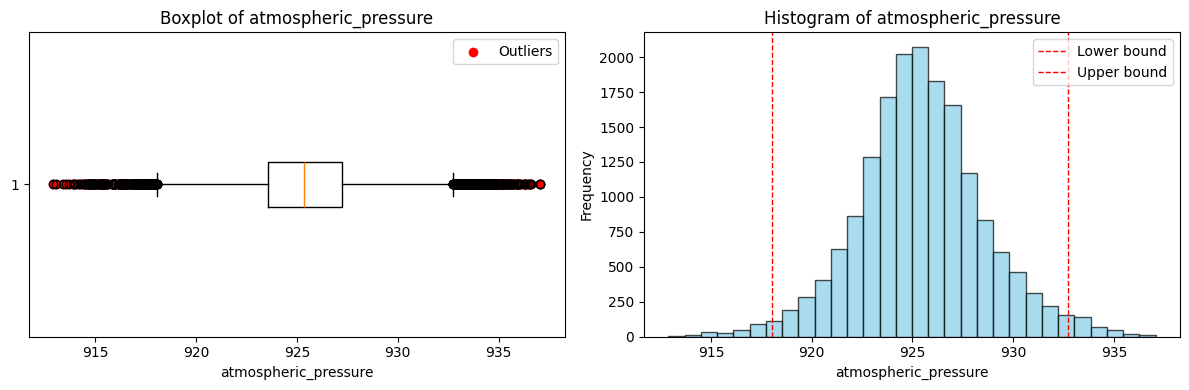

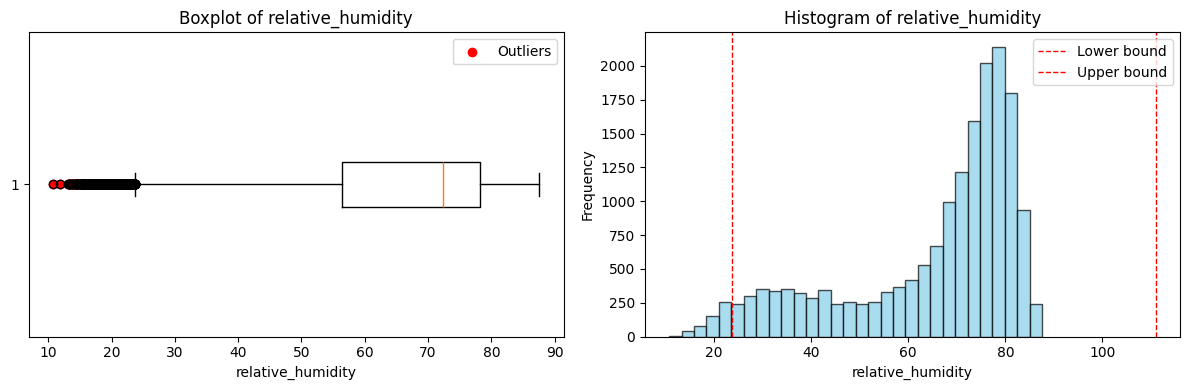

  air_temperature outlier row indices: [Timestamp('2023-03-12 11:00:00+0000', tz='UTC'), Timestamp('2023-03-12 12:00:00+0000', tz='UTC'), Timestamp('2023-03-25 16:00:00+0000', tz='UTC'), Timestamp('2023-03-25 17:00:00+0000', tz='UTC'), Timestamp('2023-03-26 10:00:00+0000', tz='UTC'), Timestamp('2023-03-26 11:00:00+0000', tz='UTC'), Timestamp('2023-03-26 12:00:00+0000', tz='UTC'), Timestamp('2023-03-26 13:00:00+0000', tz='UTC'), Timestamp('2023-03-26 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 08:00:00+0000', tz='UTC'), Timestamp('2023-03-31 09:00:00+0000', tz='UTC'), Timestamp('2023-03-31 10:00:00+0000', tz='UTC'), Timestamp('2023-03-31 11:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:0

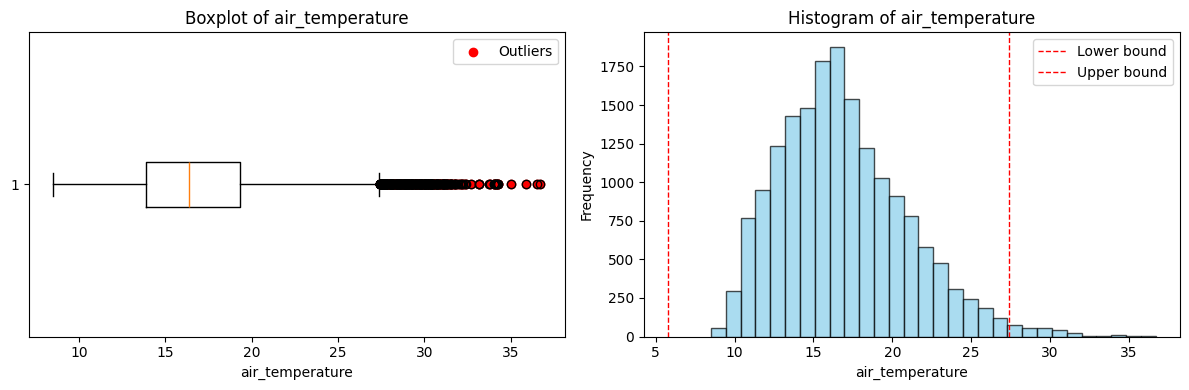

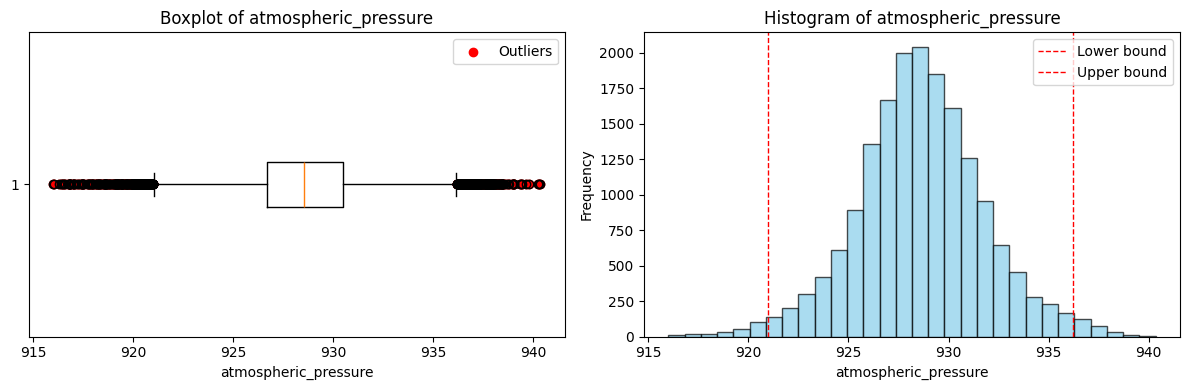

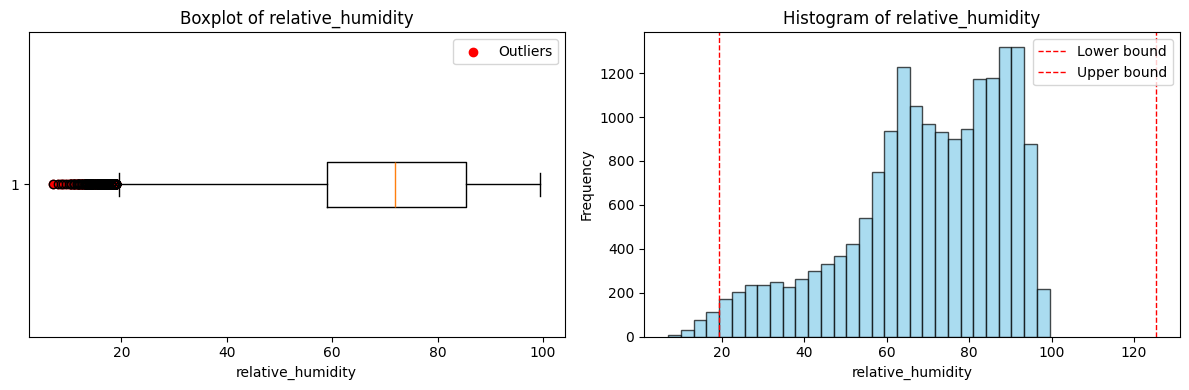

  air_temperature outlier row indices: [Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-06-28 11:00:00+0000', tz='UTC'), Timestamp('2023-06-28 12:00:00+0000', tz='UTC'), Timestamp('2023-06-28 13:00:00+0000', tz='UTC'), Timestamp('2023-06-28 14:00:00+0000', tz='UTC'), Timestamp('2023-06-28 15:00:00+0000', tz='UTC'), Timestamp('2023-06-28 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 10:00:00+0000', tz='UTC'), Timestamp('2023-06-29 11:00:00+0000', tz='UTC'), Timestamp('2023-06-29 12:00:00+0000', tz='UTC'), Timestamp('2023-06-29 13:00:00+0000', tz='UTC'), Timestamp('2023-06-29 14:00:0

In [15]:
threshold = 1.5

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    df_clean = df_hourly.drop(list(all_outlier_indices))
    dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")


## Escritura fichero 

In [16]:
for file_key, df_hourly in dataframes.items():
  print(df_hourly.describe())

       air_temperature  atmospheric_pressure  relative_humidity
count     16775.000000          16775.000000       16775.000000
mean         16.559335            928.294141          70.159493
std           3.941225              2.923374          19.038784
min           7.400000            920.600000          11.000000
25%          13.500000            926.400000          57.000000
50%          16.300000            928.200000          74.000000
75%          19.200000            930.200000          86.000000
max          27.700000            936.100000         100.000000
       air_temperature  atmospheric_pressure  relative_humidity
count     16686.000000          16686.000000       16686.000000
mean         16.855478            928.839884          70.170802
std           3.781084              2.820057          23.204175
min           8.900000            921.400000           7.000000
25%          14.100000            927.000000          58.000000
50%          16.400000            928.80